In [1]:
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Import the dataset
Powerplant_df = pd.read_csv('Powerplant.csv',sep=";" )
Powerplant_df.head()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Electrical Energy Output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
#Checking Missing Value
print(Powerplant_df.isnull().sum())

Temperature                 0
Exhaust Vacuum              0
Ambient Pressure            0
Relative Humidity           0
Electrical Energy Output    0
dtype: int64


In [5]:
Powerplant_df = Powerplant_df.astype(float)
Powerplant_df.describe()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Electrical Energy Output
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


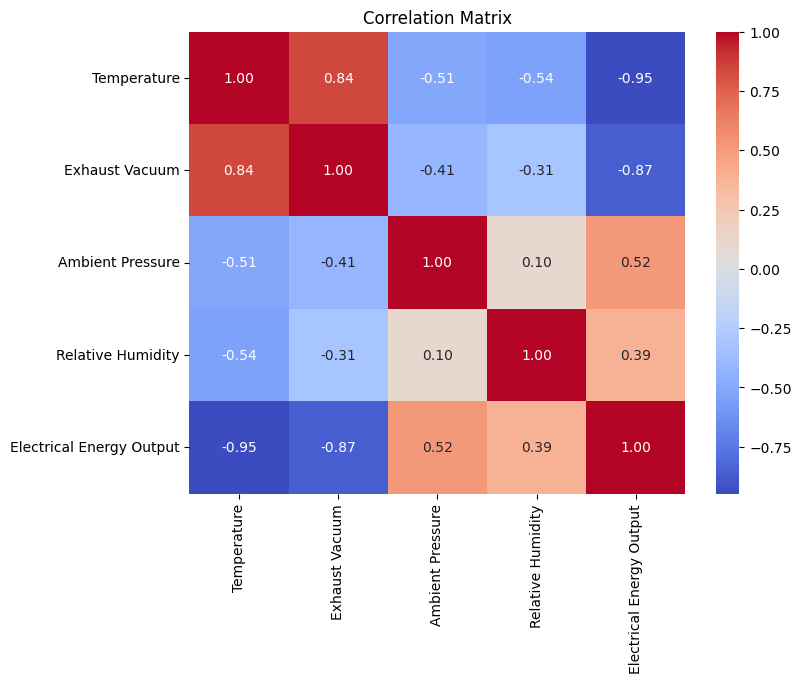

In [6]:
#Checking correlation between all variables
Powerplant_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(Powerplant_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [7]:
#We can see that Temperature, Exhaust Vacuum and Ambient Pressure are highly correlated with our target Electrical Energy Output.
#Since Temperature and Exhaust Vacuum also highly correlated each other, we will remove Exhaust Vacuum along with Relative Humidity.
Powerplant_df= Powerplant_df.drop(['Exhaust Vacuum','Relative Humidity'],axis=1)
Powerplant_df.head()

,Temperature,Ambient Pressure,Electrical Energy Output
0,14.96,1024.07,463.26
1,25.18,1020.04,444.37
2,5.11,1012.16,488.56
3,20.86,1010.24,446.48
4,10.82,1009.23,473.90


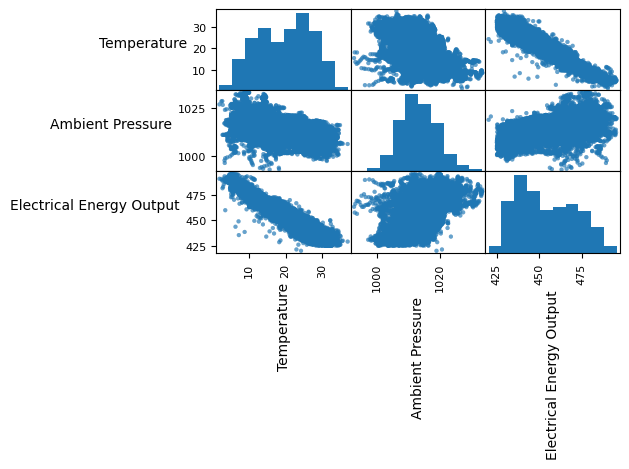

In [8]:
#Plotting the correlation
axes = pd.plotting.scatter_matrix(Powerplant_df, alpha=0.2)
# need to rotate axis labels so we can read them
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

In [9]:
#Extract the required columns and convert the resulting dataframes to NumPy arrays
X = Powerplant_df.iloc[:,[0,1]].to_numpy()
y = Powerplant_df.iloc[:,[2]].to_numpy()

In [10]:
#You should standardize your input features so the model doesn’t inadvertently favor any feature due to its magnitude. The typical way to do this is to subtract the mean and divide by the standard deviation. Scikit-learn can do this for you.

from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)
pd.DataFrame(X_std).describe().round(2)

,0,1
count,47840.00,47840.00
mean,0.00,0.00
std,1.00,1.00
min,-2.39,-3.43
25%,-0.82,-0.70
50%,0.09,-0.05
75%,0.81,0.67
max,2.34,3.37


In [11]:
#Build train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.3,random_state=42)


In [12]:
from sklearn import linear_model
# create a model object
regressor = linear_model.LinearRegression()
# train the model in the training data
regressor.fit(X_train, y_train)
# Print the coefficients
coef_ = regressor.coef_
intercept_ = regressor.intercept_
print ('Coefficients: ',coef_)
print ('Intercept: ',intercept_)

Coefficients:  [[-15.74220479   0.85062947]]
Intercept:  [454.34303538]


In [13]:
# You can transform your model’s parameters back to the original space prior to standardization as follows.
# Get the standard scaler's mean and standard deviation parameters
means_ = std_scaler.mean_
std_devs_ = np.sqrt(std_scaler.var_)
# The least squares parameters can be calculated relative to the original, unstandardized feature space as:
coef_original = coef_ / std_devs_
intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)
print ('Coefficients: ', coef_original)
print ('Intercept: ', intercept_original)


Coefficients:  [[-2.11245677  0.14324043]]
Intercept:  [350.7157468]


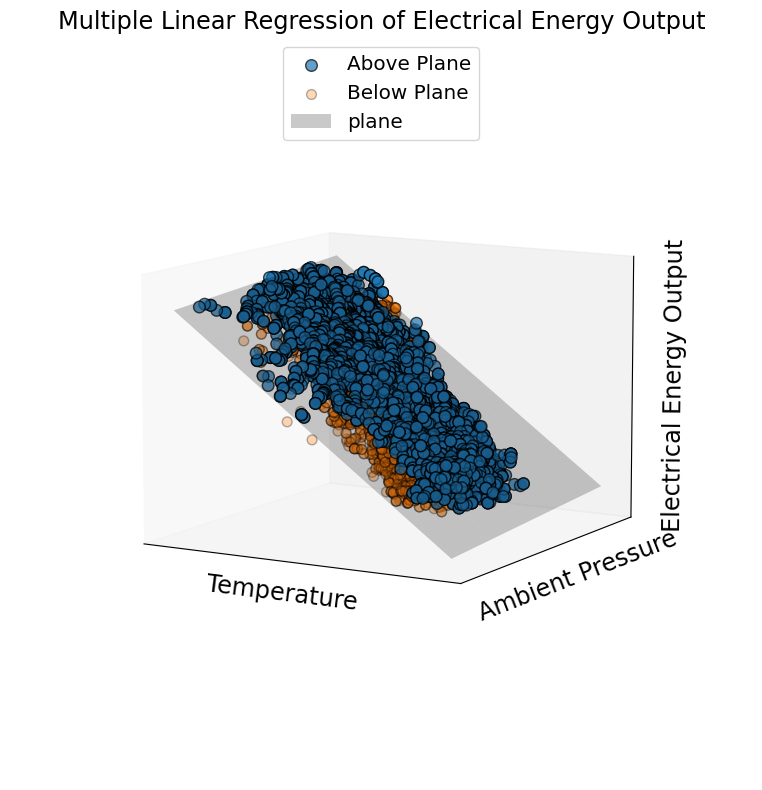

In [14]:
# Visualize model output
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)
# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
np.linspace(X2.min(), X2.max(), 100))
y_surf = intercept_ + coef_[0,0] * x1_surf + coef_[0,1] * x2_surf
# Predict y values using trained regression model to compare with actual y_test␣for above/below plane colors
y_pred = regressor.predict(X_test.reshape(-1, 1)) if X_test.ndim == 1 else regressor.predict(X_test)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred
above_plane = above_plane[:,0]
below_plane = below_plane[:,0]
# Plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane], label="Above Plane",s=70,alpha=.7,ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane], label="Below Plane",s=50,alpha=.3,ec='k')
# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21,label='plane')
# Set view and labels
ax.view_init(elev=10)
ax.legend(fontsize='x-large',loc='upper center')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel('Temperature', fontsize='xx-large')
ax.set_ylabel('Ambient Pressure', fontsize='xx-large')
ax.set_zlabel('Electrical Energy Output', fontsize='xx-large')
ax.set_title('Multiple Linear Regression of Electrical Energy Output', fontsize='xx-large')
plt.tight_layout()
plt.show()

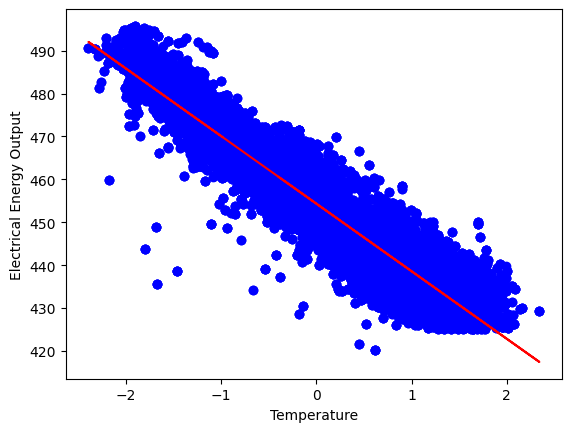

In [15]:
# Instead of making a 3D plot, which is difficult to interpret, you can look at vertical slices of the 3D plot by plotting each variable separately as a best-fit line using the corresponding regression parameters.
plt.scatter(X_train[:,0], y_train, color='blue')
plt.plot(X_train[:,0], coef_[0,0] * X_train[:,0] + intercept_[0], '-r')
plt.xlabel("Temperature")
plt.ylabel("Electrical Energy Output")
plt.show()

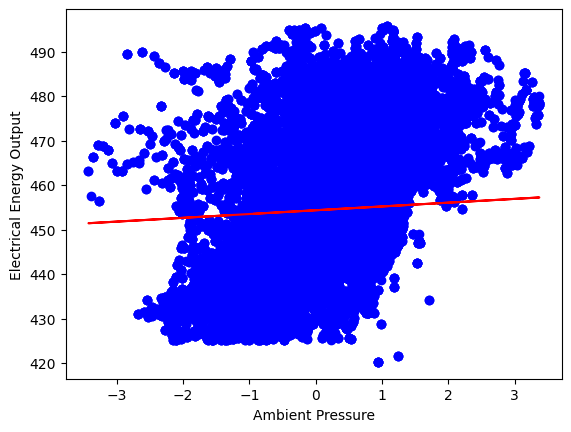

In [16]:
plt.scatter(X_train[:,1], y_train, color='blue')
plt.plot(X_train[:,1], coef_[0,1] * X_train[:,1] + intercept_[0], '-r')
plt.xlabel("Ambient Pressure")
plt.ylabel("Electrical Energy Output")
plt.show()

In [17]:
#Checking model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

# Use the predict method to make test predictions
y_pred = regressor.predict( X_test.reshape(-1,2))

print("Mean absolute error: %.2f" % mean_absolute_error(y_pred, y_test))
print("Mean squared error: %.2f" % mean_squared_error(y_pred, y_test))
print("Root mean squared error: %.2f" % root_mean_squared_error(y_pred, y_test))
print("R2-score: %.2f" % r2_score( y_pred, y_test) )

Mean absolute error: 4.24
Mean squared error: 28.28
Root mean squared error: 5.32
R2-score: 0.89


In [18]:
# The model's average prediction error is 4.24 units.
# The average deviation of predictions from actual values is around 5.32 units.
# A score of 0.89 means that 89% of the variance in the data is explained by the model.

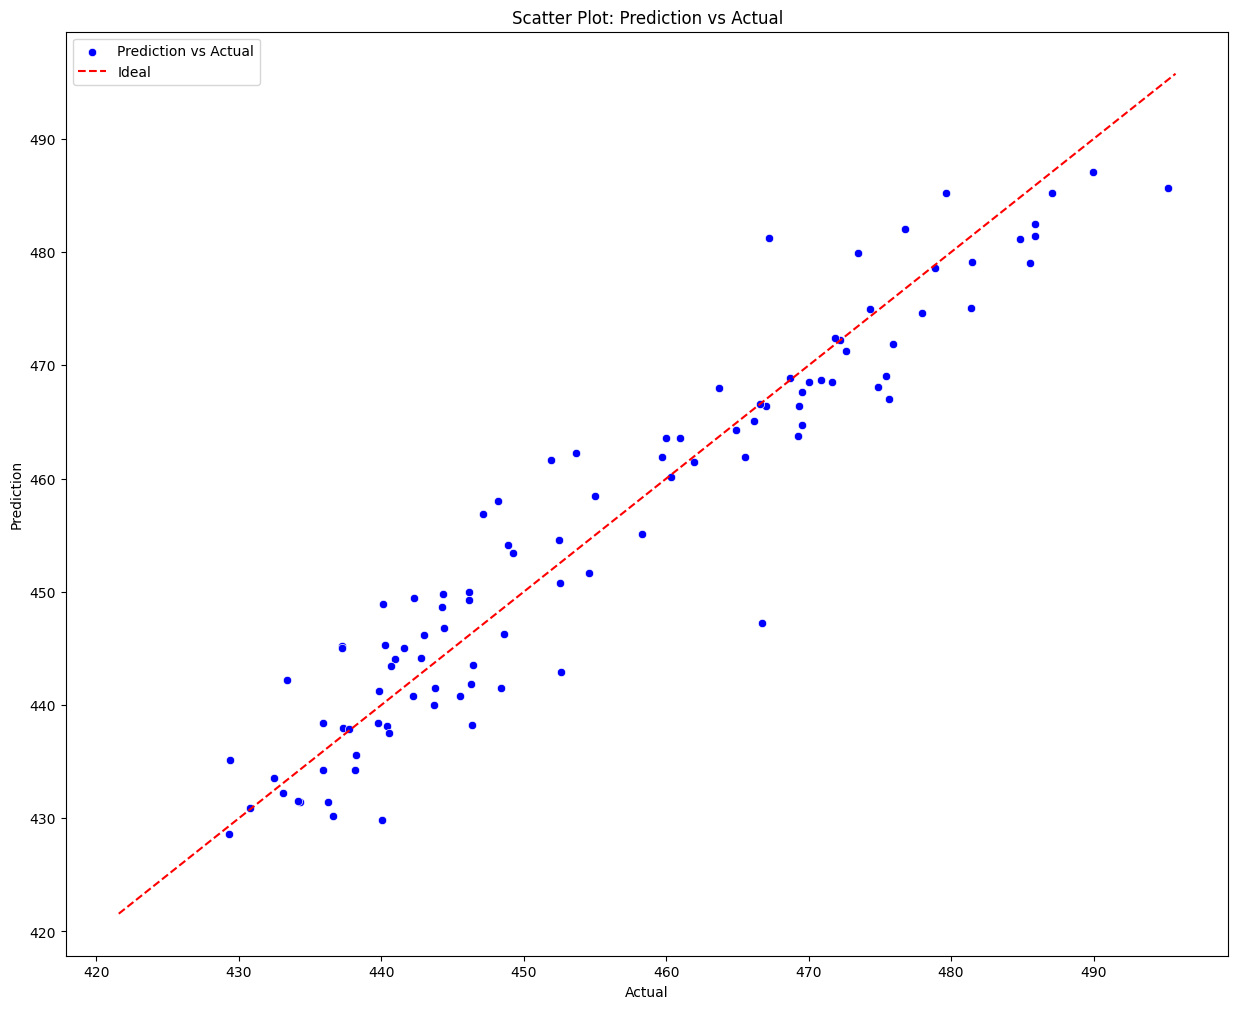

In [19]:
#Visualize actual data vs prediction 
y_test_1d = np.ravel(y_test)  # atau y_test.flatten()
y_pred_1d = np.ravel(y_pred)  # atau y_pred.flatten()
sample_idx = np.random.choice(len(y_test_1d), size=100, replace=False)
plt.figure(figsize=(15,12))
sns.scatterplot(x=y_test_1d[sample_idx], y=y_pred_1d[sample_idx], color="blue", label="Prediction vs Actual")

plt.plot([min(y_test_1d), max(y_test_1d)], [min(y_test_1d), max(y_test_1d)], color="red", linestyle="--", label="Ideal")

plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Scatter Plot: Prediction vs Actual")
plt.legend()
plt.show()

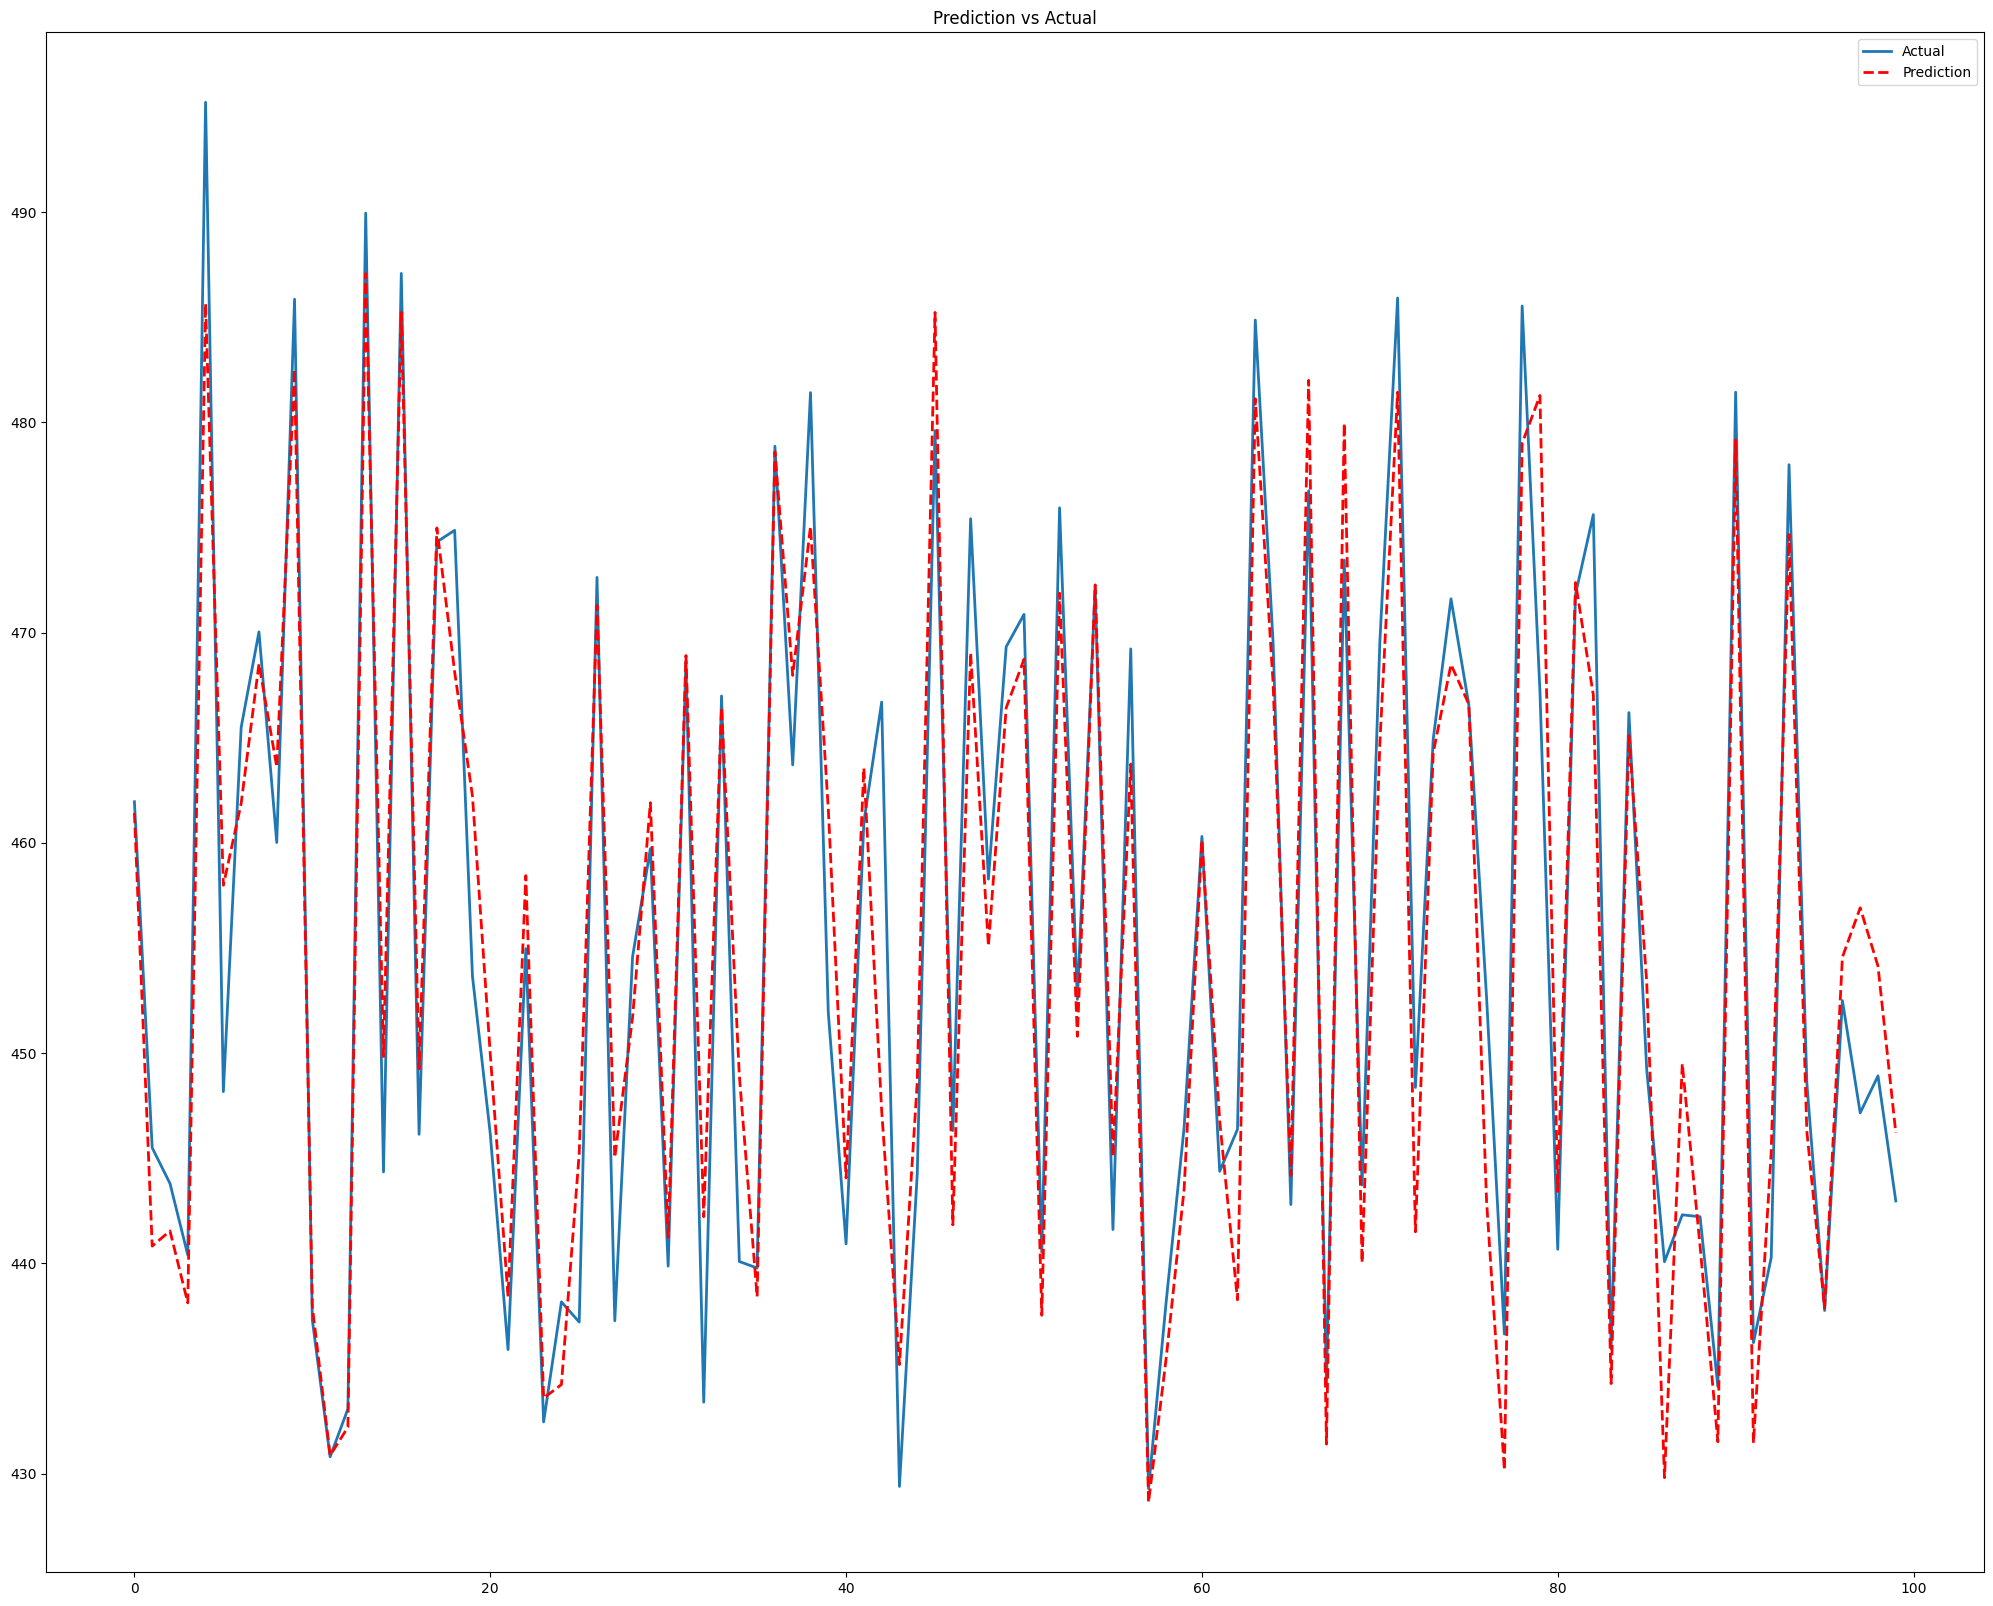

In [20]:
# Create figure
plt.figure(figsize=(25,20))
#Line plots for predictions compared to actual and ideal predictions
plt.plot(y_test_1d[sample_idx], label="Actual", lw=2)
plt.plot(y_pred_1d[sample_idx], '--', lw=2, color='red', label="Prediction")
plt.title("Prediction vs Actual",)
plt.legend()
plt.show()
